In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import pandas as pd
import keras
import os
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array
print(img_to_array)
from tensorflow.keras.utils import load_img
print(load_img)
from keras.applications.vgg19 import VGG19 , preprocess_input , decode_predictions

2022-11-27 13:38:24.784498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 13:38:29.427809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 13:38:29.427849: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 13:38:38.159348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

<function img_to_array at 0x7ff1a6020d30>
<function load_img at 0x7ff1a6020e50>


In [2]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
train = train_datagen.flow_from_directory(directory= '/workspaces/test/datasets/data_distribution_for_SVM/train' , target_size=(256, 256), batch_size=32)
val = val_datagen.flow_from_directory(directory= '/workspaces/test/datasets/data_distribution_for_SVM/test' , target_size=(256, 256), batch_size=32)

Found 8751 images belonging to 38 classes.
Found 10547 images belonging to 38 classes.


In [4]:
t_img, t_label = train.next()

In [5]:
def show_img(img_array , label):
    for im , l in zip(img_array , label):
     plt.figure(figsize=(5, 5))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(label[i])
        plt.axis('off')
    plt.show()

In [6]:
plot_img = (t_img[:3] , t_label[:3])

# model

In [7]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D , Flatten
import keras

In [8]:
Base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

2022-11-27 13:39:09.461704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-27 13:39:09.461743: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 13:39:09.461766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-7d68fb): /proc/driver/nvidia/version does not exist
2022-11-27 13:39:09.462207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
for layer in Base_model.layers:
    layer.trainable = False

In [10]:
Base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
m = Flatten()(Base_model.output)
m = Dense(38, activation='softmax')(m)

In [12]:
models = Model(Base_model.input, m)

In [13]:
models.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
models.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3 , min_delta=0.01)
mc = ModelCheckpoint(filepath='best_model.h5',
 monitor='val_accuracy',
   min_delta=0.01 ,
    verbose=1 ,
     save_best_only=True ,
     patience=3)
cb = [es, mc]     

In [16]:
his = models.fit_generator(train,
 validation_data=val,
 validation_steps=16,
 steps_per_epoch=16, 
 epochs=50,
 verbose=1,
 callbacks=cb)

/tmp/ipykernel_4110/1296804116.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = models.fit_generator(train,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 23.6304 - accuracy: 0.3008
Epoch 1: val_accuracy improved from -inf to 0.65039, saving model to best_model.h5
16/16 [==============================] - 58s 4s/step - loss: 23.6304 - accuracy: 0.3008 - val_loss: 10.4299 - val_accuracy: 0.6504
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 11.2085 - accuracy: 0.6074
Epoch 2: val_accuracy improved from 0.65039 to 0.65234, saving model to best_model.h5
16/16 [==============================] - 55s 4s/step - loss: 11.2085 - accuracy: 0.6074 - val_loss: 8.1296 - val_accuracy: 0.6523
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 11.4315 - accuracy: 0.6061
Epoch 3: val_accuracy improved from 0.65234 to 0.69336, saving model to best_model.h5
16/16 [==============================] - 56s 4s/step - loss: 11.4315 - accuracy: 0.6061 - val_loss: 8.4163 - val_accuracy: 0.6934
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 8

In [17]:
h = his.history
h.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

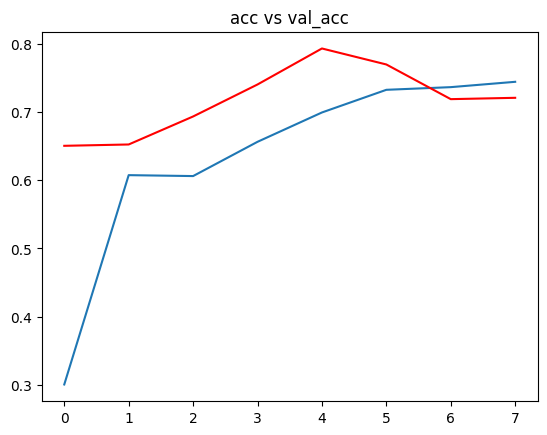

In [18]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title('acc vs val_acc')
plt.show()

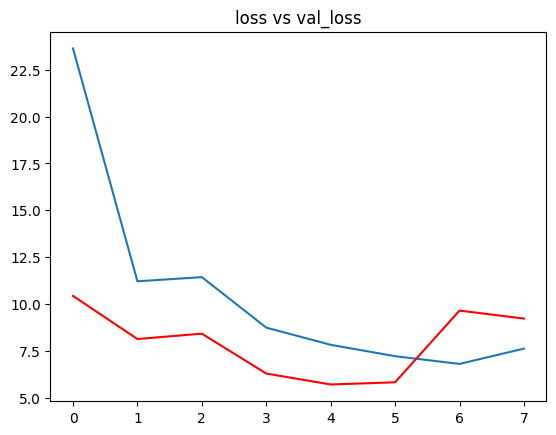

In [19]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title('loss vs val_loss')
plt.show()

In [20]:
from keras.models import load_model
Model = load_model('/workspaces/test/best_model.h5')
acc = Model.evaluate_generator(val)[1]
print(f"the accuracy of our model is {acc*100} %")

/tmp/ipykernel_4110/510584569.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = Model.evaluate_generator(val)[1]


the accuracy of our model is 77.10249423980713 %


In [50]:
ref = dict (zip (list (train.class_indices.values()) , list (train.class_indices.keys())))

In [51]:
def prediction(path):
    img = load_img(path, target_size=(256, 256))
    i = img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im, axis=0)
    pred = np.argmax(Model.predict(img))
    print(f"the prediction of the image is {ref[pred]}")

In [59]:
path = "/workspaces/test/potato.jpeg"
prediction(path)

1/1 [==============================] - 0s 83ms/step
the prediction of the image is 26
